# Cass-Koopmans Optimal Growth Model

In [1]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
@njit
def u(c, γ):
    '''
    Utility function
    ASIDE: If you have a utility function that is hard to solve by hand
    you can use automatic or symbolic  differentiation
    See https://github.com/HIPS/autograd
    '''
    if γ == 1:
        # If γ = 1 we can show via L'hopital's Rule that the utility
        # becomes log
        return np.log(c)
    else:
        return c**(1 - γ) / (1 - γ)

@njit
def u_prime(c, γ):
    '''Derivative of utility'''
    if γ == 1:
        return 1 / c
    else:
        return c**(-γ)

@njit
def u_prime_inv(c, γ):
    '''Inverse utility'''
    if γ == 1:
        return c
    else:
        return c**(-1 / γ)

@njit
def f(A, k, α):
    '''Production function'''
    return A * k**α

@njit
def f_prime(A, k, α):
    '''Derivative of production function'''
    return α * A * k**(α - 1)

@njit
def f_prime_inv(A, k, α):
    return (k / (A * α))**(1 / (α - 1))

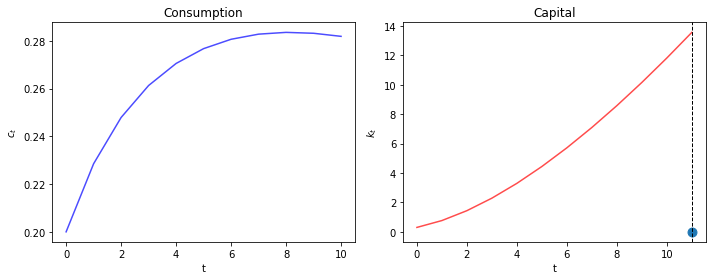

In [3]:
# Parameters
γ = 2
δ = 0.02
β = 0.95
α = 0.33
A = 1

# Initial guesses
T = 10
c = np.zeros(T+1)  # T periods of consumption initialized to 0
# T periods of capital initialized to 0 (T+2 to include t+1 variable as well)
k = np.zeros(T+2)
k[0] = 0.3  # Initial k
c[0] = 0.2  # Guess of c_0

@njit
def shooting_method(c, # Initial consumption
                    k,   # Initial capital
                    γ,   # Coefficient of relative risk aversion
                    δ,   # Depreciation rate on capital# Depreciation rate
                    β,   # Discount factor
                    α,   # Return to capital per capita
                    A):  # Technology

    T = len(c) - 1

    for t in range(T):
        # Equation 1 with inequality
        k[t+1] = f(A=A, k=k[t], α=α) + (1 - δ) * k[t] - c[t]
        if k[t+1] < 0:   # Ensure nonnegativity
            k[t+1] = 0

      # Equation 2: We keep in the general form to show how we would
      # solve if we didn't want to do any simplification

        if β * (f_prime(A=A, k=k[t+1], α=α) + (1 - δ)) == np.inf:
            # This only occurs if k[t+1] is 0, in which case, we won't
            # produce anything next period, so consumption will have to be 0
            c[t+1] = 0
        else:
            c[t+1] = u_prime_inv(u_prime(c=c[t], γ=γ) \
            / (β * (f_prime(A=A, k=k[t+1], α=α) + (1 - δ))), γ=γ)

    # Terminal condition calculation
    k[T+1] = f(A=A, k=k[T], α=α) + (1 - δ) * k[T] - c[T]

    return c, k

paths = shooting_method(c, k, γ, δ, β, α, A)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
colors = ['blue', 'red']
titles = ['Consumption', 'Capital']
ylabels = ['$c_t$', '$k_t$']

for path, color, title, y, ax in zip(paths, colors, titles, ylabels, axes):
    ax.plot(path, c=color, alpha=0.7)
    ax.set(title=title, ylabel=y, xlabel='t')

ax.scatter(T+1, 0, s=80)
ax.axvline(T+1, color='k', ls='--', lw=1)

plt.tight_layout()
plt.show()

In [4]:
@njit
def bisection_method(c,
                     k,
                     γ,              # Coefficient of relative risk aversion
                     δ,              # Depreciation rate
                     β,              # Discount factor
                     α,              # Return to capital per capita
                     A,              # Technology
                     tol=1e-4,
                     max_iter=1e4,
                     terminal=0):    # Value we are shooting towards

    T = len(c) - 1
    i = 1                            # Initial iteration
    c_high = f(k=k[0], α=α, A=A)     # Initial high value of c
    c_low = 0                        # Initial low value of c

    path_c, path_k = shooting_method(c, k, γ, δ, β, α, A)

    while (np.abs((path_k[T+1] - terminal)) > tol or path_k[T] == terminal) \
        and i < max_iter:

        if path_k[T+1] - terminal > tol:
            # If assets are too high the c[0] we chose is now a lower bound
            # on possible values of c[0]
            c_low = c[0]
        elif path_k[T+1] - terminal < -tol:
            # If assets fell too quickly, the c[0] we chose is now an upper
            # bound on possible values of c[0]
            c_high=c[0]
        elif path_k[T] == terminal:
            # If assets fell  too quickly, the c[0] we chose is now an upper
            # bound on possible values of c[0]
            c_high=c[0]

        c[0] = (c_high + c_low) / 2  # This is the bisection part
        path_c, path_k = shooting_method(c, k, γ, δ, β, α, A)
        i += 1

    if np.abs(path_k[T+1] - terminal) < tol and path_k[T] != terminal:
        print('Converged successfully on iteration', i-1)
    else:
        print('Failed to converge and hit maximum iteration')

    μ = u_prime(c=path_c, γ=γ)
    return path_c, path_k, μ

Converged successfully on iteration 18


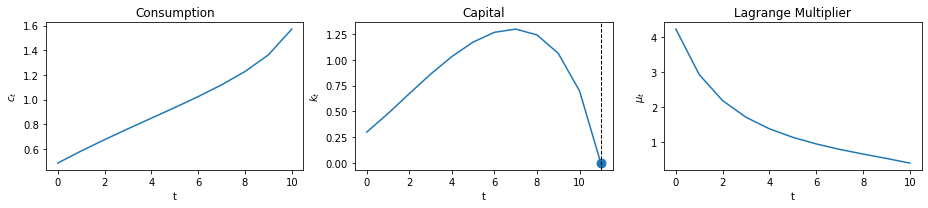

In [5]:
T = 10
c = np.zeros(T+1) # T periods of consumption initialized to 0
# T periods of capital initialized to 0. T+2 to include t+1 variable as well
k = np.zeros(T+2)

k[0] = 0.3 # initial k
c[0] = 0.3 # our guess of c_0

paths = bisection_method(c, k, γ, δ, β, α, A)

def plot_paths(paths, axes=None, ss=None):

    T = len(paths[0])

    if axes is None:
        fix, axes = plt.subplots(1, 3, figsize=(13, 3))

    ylabels = ['$c_t$', '$k_t$', '$\mu_t$']
    titles = ['Consumption', 'Capital', 'Lagrange Multiplier']

    for path, y, title, ax in zip(paths, ylabels, titles, axes):
        ax.plot(path)
        ax.set(ylabel=y, title=title, xlabel='t')

    # Plot steady state value of capital
    if ss is not None:
        axes[1].axhline(ss, c='k', ls='--', lw=1)

    axes[1].axvline(T, c='k', ls='--', lw=1)
    axes[1].scatter(T, paths[1][-1], s=80)
    plt.tight_layout()

plot_paths(paths)

In [6]:
ρ = 1 / β - 1
k_ss = f_prime_inv(k=ρ+δ, A=A, α=α)

print(f'steady state for capital is: {k_ss}')

steady state for capital is: 9.57583816331462


Converged successfully on iteration 39


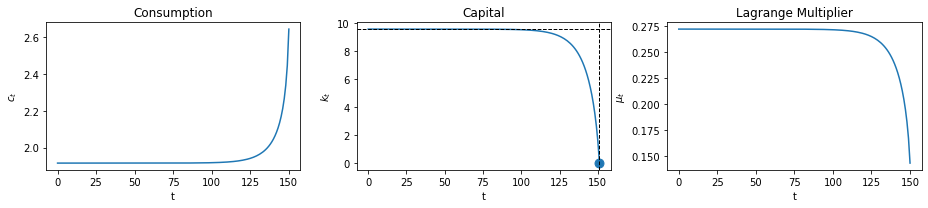

In [7]:
T = 150
c = np.zeros(T+1)
k = np.zeros(T+2)
c[0] = 0.3
k[0] = k_ss  # Start at steady state
paths = bisection_method(c, k, γ, δ, β, α, A)

plot_paths(paths, ss=k_ss)

Converged successfully on iteration 39


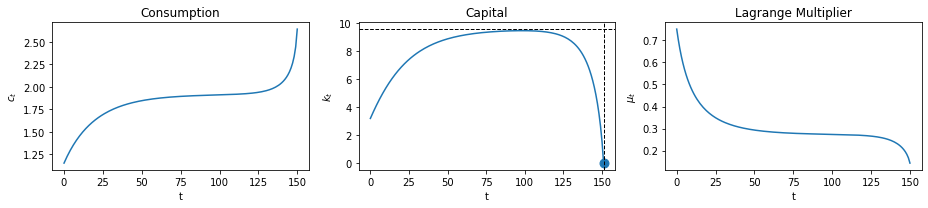

In [8]:
k_init = k_ss / 3   # Below our steady state
T = 150
c = np.zeros(T+1)
k = np.zeros(T+2)
c[0] = 0.3
k[0] = k_init
paths = bisection_method(c, k, γ, δ, β, α, A)

plot_paths(paths, ss=k_ss)

Converged successfully on iteration 39
Converged successfully on iteration 26
Converged successfully on iteration 25
Converged successfully on iteration 22


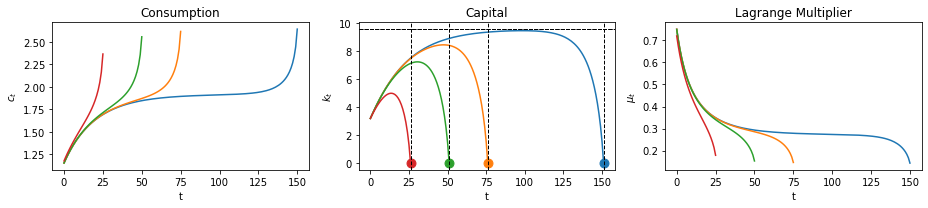

In [9]:
T_list = (150, 75, 50, 25)

fix, axes = plt.subplots(1, 3, figsize=(13, 3))

for T in T_list:
    c = np.zeros(T+1)
    k = np.zeros(T+2)
    c[0] = 0.3
    k[0] = k_init
    paths = bisection_method(c, k, γ, δ, β, α, A)
    plot_paths(paths, ss=k_ss, axes=axes)

Failed to converge and hit maximum iteration
Converged successfully on iteration 39
Converged successfully on iteration 25
Converged successfully on iteration 22


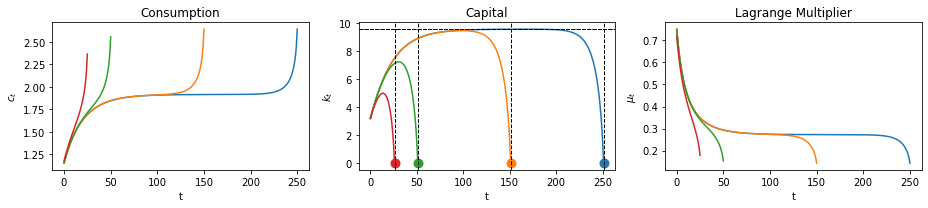

In [10]:
T_list = (250, 150, 50, 25)

fix, axes = plt.subplots(1, 3, figsize=(13, 3))

for T in T_list:
    c = np.zeros(T+1)
    k = np.zeros(T+2)
    c[0] = 0.3
    k[0] = k_init
    paths = bisection_method(c, k, γ, δ, β, α, A)
    plot_paths(paths, ss=k_ss, axes=axes)

Failed to converge and hit maximum iteration
Converged successfully on iteration 39
Converged successfully on iteration 26
Converged successfully on iteration 25


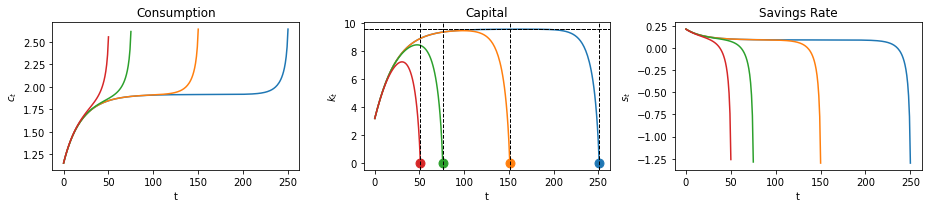

In [11]:
@njit
def S(K):
    '''Aggregate savings'''
    T = len(K) - 2
    S = np.zeros(T+1)
    for t in range(T+1):
        S[t] = K[t+1] - (1 - δ) * K[t]
    return S

@njit
def s(K):
    '''Savings rate'''
    T = len(K) - 2
    Y = f(A, K, α)
    Y = Y[0:T+1]
    s = S(K) / Y
    return s

def plot_savings(paths, c_ss=None, k_ss=None, s_ss=None, axes=None):

    T = len(paths[0])
    k_star = paths[1]
    savings_path = s(k_star)
    new_paths = (paths[0], paths[1], savings_path)

    if axes is None:
        fix, axes = plt.subplots(1, 3, figsize=(13, 3))

    ylabels = ['$c_t$', '$k_t$', '$s_t$']
    titles = ['Consumption', 'Capital', 'Savings Rate']

    for path, y, title, ax in zip(new_paths, ylabels, titles, axes):
        ax.plot(path)
        ax.set(ylabel=y, title=title, xlabel='t')

    # Plot steady state value of consumption
    if c_ss is not None:
        axes[0].axhline(c_ss, c='k', ls='--', lw=1)

    # Plot steady state value of capital
    if k_ss is not None:
        axes[1].axhline(k_ss, c='k', ls='--', lw=1)

    # Plot steady state value of savings
    if s_ss is not None:
        axes[2].axhline(s_ss, c='k', ls='--', lw=1)

    axes[1].axvline(T, c='k', ls='--', lw=1)
    axes[1].scatter(T, k_star[-1], s=80)
    plt.tight_layout()

T_list = (250, 150, 75, 50)

fix, axes = plt.subplots(1, 3, figsize=(13, 3))

for T in T_list:
    c = np.zeros(T+1)
    k = np.zeros(T+2)
    c[0] = 0.3
    k[0] = k_init
    paths = bisection_method(c, k, γ, δ, β, α, A)
    plot_savings(paths, k_ss=k_ss, axes=axes)

Converged successfully on iteration 35


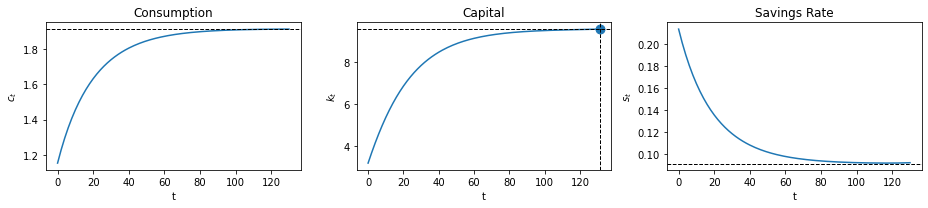

In [12]:
T = 130

# Steady states
S_ss = δ * k_ss
c_ss = f(A, k_ss, α) - S_ss
s_ss = S_ss / f(A, k_ss, α)

c = np.zeros(T+1)
k = np.zeros(T+2)
c[0] = 0.3
k[0] = k_ss / 3         # Start below steady state
paths = bisection_method(c, k, γ, δ, β, α, A, terminal=k_ss)
plot_savings(paths, k_ss=k_ss, s_ss=s_ss, c_ss=c_ss)

Converged successfully on iteration 31


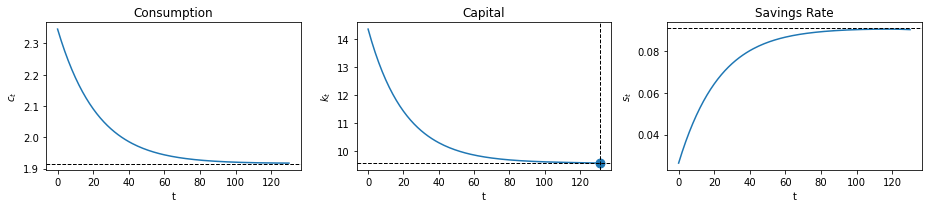

In [13]:
T = 130

c = np.zeros(T+1)
k = np.zeros(T+2)
c[0] = 0.3
k[0] = k_ss * 1.5   # Start above steady state
paths = bisection_method(c, k, γ, δ, β, α, A, terminal=k_ss)
plot_savings(paths, k_ss=k_ss, s_ss=s_ss, c_ss=c_ss)

In [14]:
@njit
def q_func(β, c, γ):
    # Here we choose numeraire to be u'(c_0) -- this is q^(t_0)_t
    T = len(c) - 2
    q = np.zeros(T+1)
    q[0] = 1
    for t in range(1, T+2):
        q[t] = β**t * u_prime(c[t], γ)
    return q

@njit
def w_func(A, k, α):
    w = f(A, k, α) - k * f_prime(A, k, α)
    return w

@njit
def η_func(A, k, α):
    η = f_prime(A, k, α)
    return η

Failed to converge and hit maximum iteration
Converged successfully on iteration 39
Converged successfully on iteration 26
Converged successfully on iteration 25


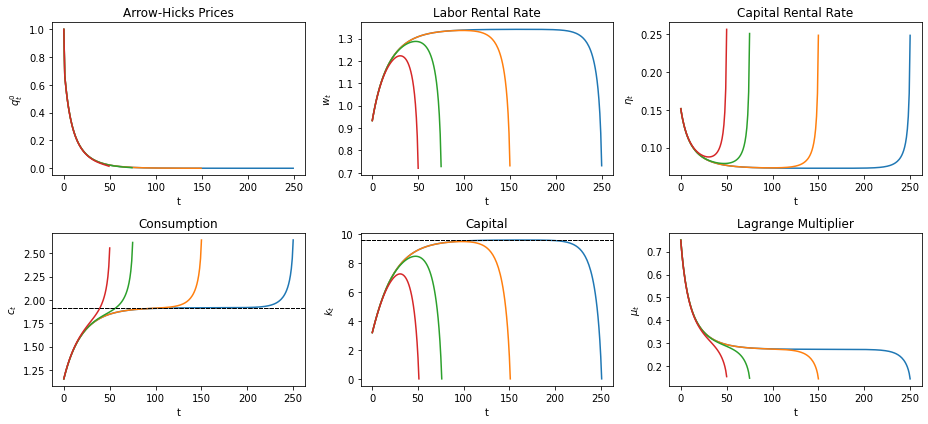

In [15]:
T_list = (250, 150, 75, 50)

fix, axes = plt.subplots(2, 3, figsize=(13, 6))
titles = ['Arrow-Hicks Prices', 'Labor Rental Rate', 'Capital Rental Rate',
          'Consumption', 'Capital', 'Lagrange Multiplier']
ylabels = ['$q_t^0$', '$w_t$', '$\eta_t$', '$c_t$', '$k_t$', '$\mu_t$']

for T in T_list:
    c = np.zeros(T+1)
    k = np.zeros(T+2)
    c[0] = 0.3
    k[0] = k_ss / 3
    c, k, μ = bisection_method(c, k, γ, δ, β, α, A)

    q = q_func(β, c, γ)
    w = w_func(β, k, α)[:-1]
    η = η_func(A, k, α)[:-1]
    plots = [q, w, η, c, k, μ]

    for ax, plot, title, y in zip(axes.flatten(), plots, titles, ylabels):
        ax.plot(plot)
        ax.set(title=title, ylabel=y, xlabel='t')
        if title is 'Capital':
            ax.axhline(k_ss, lw=1, ls='--', c='k')
        if title is 'Consumption':
            ax.axhline(c_ss, lw=1, ls='--', c='k')


plt.tight_layout()
plt.show()

Converged successfully on iteration 44
Converged successfully on iteration 37
Converged successfully on iteration 37
Converged successfully on iteration 37


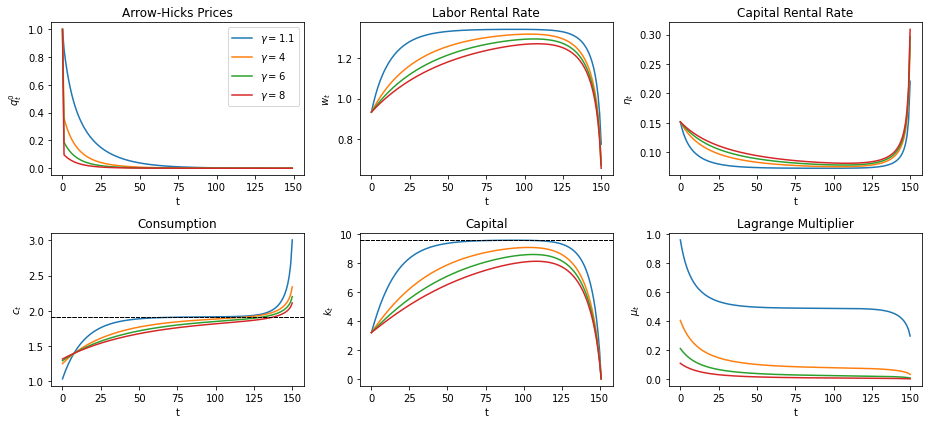

In [16]:
γ_list = (1.1, 4, 6, 8)
T = 150

fix, axes = plt.subplots(2, 3, figsize=(13, 6))

for γ in γ_list:
    c = np.zeros(T+1)
    k = np.zeros(T+2)
    c[0] = 0.3
    k[0] = k_ss / 3
    c, k, μ = bisection_method(c, k, γ, δ, β, α, A)

    q = q_func(β, c, γ)
    w = w_func(β, k, α)[:-1]
    η = η_func(A, k, α)[:-1]
    plots = [q, w, η, c, k, μ]

    for ax, plot, title, y in zip(axes.flatten(), plots, titles, ylabels):
        ax.plot(plot, label=f'$\gamma = {γ}$')
        ax.set(title=title, ylabel=y, xlabel='t')
        if title is 'Capital':
            ax.axhline(k_ss, lw=1, ls='--', c='k')
        if title is 'Consumption':
            ax.axhline(c_ss, lw=1, ls='--', c='k')

axes[0, 0].legend()
plt.tight_layout()
plt.show()

Converged successfully on iteration 39
Converged successfully on iteration 26
Converged successfully on iteration 25


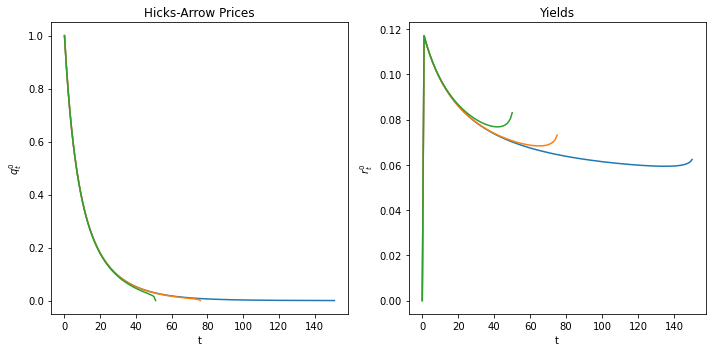

In [17]:
@njit
def q_func(t_0, β, c, γ):
    # Here we choose numeraire to be u'(c_0) -- this is q^(t_0)_t
    T = len(c)
    q = np.zeros(T+1-t_0)
    q[0] = 1
    for t in range(t_0+1, T):
        q[t-t_0] = β**(t - t_0) * u_prime(c[t], γ) / u_prime(c[t_0], γ)
    return q

@njit
def r_func(t_0, β, c, γ):
    '''Yield to maturity'''
    T = len(c) - 1
    r = np.zeros(T+1-t_0)
    for t in range(t_0+1, T+1):
        r[t-t_0]= -np.log(q_func(t_0, β, c, γ)[t-t_0]) / (t - t_0)
    return r

t_0 = 0
T_list = [150, 75, 50]
γ = 2
titles = ['Hicks-Arrow Prices', 'Yields']
ylabels = ['$q_t^0$', '$r_t^0$']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for T in T_list:
    c = np.zeros(T+1)
    k = np.zeros(T+2)
    c[0] = 0.3
    k[0] = k_ss / 3
    c, k, μ = bisection_method(c, k, γ, δ, β, α, A)
    q = q_func(t_0, β, c, γ)
    r = r_func(t_0, β, c, γ)

    for ax, plot, title, y in zip(axes, (q, r), titles, ylabels):
        ax.plot(plot)
        ax.set(title=title, ylabel=y, xlabel='t')

plt.tight_layout()
plt.show()

Converged successfully on iteration 39
Converged successfully on iteration 26
Converged successfully on iteration 25


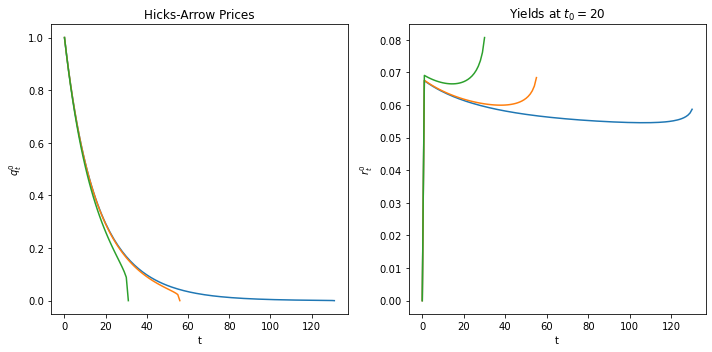

In [18]:
t_0 = 20

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for T in T_list:
    c = np.zeros(T+1)
    k = np.zeros(T+2)
    c[0] = 0.3
    k[0] = k_ss / 3
    c, k, μ = bisection_method(c, k, γ, δ, β, α, A)
    q = q_func(t_0, β, c, γ)
    r = r_func(t_0, β, c, γ)

    for ax, plot, title, y in zip(axes, (q, r), titles, ylabels):
        ax.plot(plot)
        ax.set(title=title, ylabel=y, xlabel='t')

axes[1].set_title(f'Yields at $t_0 = {t_0}$')
plt.tight_layout()
plt.show()